In [1]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
%matplotlib inline

here in tplot
osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [36]:
# parameters cell
meshpath = '/p/project/chhb19/streffing1/input/fesom2/core2/'
abg = [0, 0, 0]
variable = 'temp'
input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/fesom/",
               ]
input_names = ['HIST']
years = range(1990, 2014)
reference_path = '/p/project/chhb19/streffing1/postprocessing/climatologies/fdiag/output_awicm3/'
reference_name = 'clim'
reference_years = 1958
rowscol=[1,1]
bbox = [-180, 180, -80, 90]
res = [360, 180]
mapproj='pc'
figsize=(6, 4.5)
depth = 0
levels = [-5, 5, 21]
units = r'$^\circ$C'
dpi=300
how="mean"
ofile = None

In [37]:
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [38]:
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2


In [39]:
plotds = OrderedDict()
data_reference = pf.get_data(reference_path, variable, reference_years, mesh, depth = depth, how=how, compute=True, silent=True)
plotds[depth] = {}
for exp_path, exp_name  in zip(input_paths, input_names):
    data_test      = pf.get_data(exp_path, variable, years, mesh, depth = depth, how=how, compute=True, silent=True)
    data_difference= data_test - data_reference
    title = exp_name+" - "+reference_name
    plotds[depth][title] = {}
    plotds[depth][title]['data'] = data_difference
    if (data_difference.max() == data_difference.min() == 0):
        plotds[depth][title]['nodiff'] = True
    else:
        plotds[depth][title]['nodiff'] = False

('nod2',)
False
False
True
('nod2',)
False
False
True


In [40]:
def data_to_plot(plotds, depth):
    plot_data = []
    plot_names = []
    for key, value in plotds[depth].items():
        if value['nodiff'] is False:
            plot_data.append(value['data'])
            plot_names.append(key)
                
    return plot_data, plot_names

In [41]:
plot_data, plot_names = data_to_plot(plotds, depth)
if not plot_data:
    print('There is no difference between fields')
    identical = True
else:
    identical = False

if len(plot_data) == 1:
    plot_data = plot_data[0]
    plot_names = plot_names[0]


In [42]:
import inspect
inspect.getfile(pf.plot)

'/p/project/chhb19/jstreffi/software/pyfesom2/pyfesom2/plotting.py'

In [9]:
def get_cmap(cmap=None):
    """Get the color map.
    Parameters
    ----------
    cmap: str, mpl.colors.Colormap
        The colormap can be provided as the name (should be in matplotlib or cmocean colormaps),
        or as matplotlib colormap object.
    Returns
    -------
    colormap:mpl.colors.Colormap
        Matplotlib colormap object.
    """
    if cmap:
        if isinstance(cmap, (mpl.colors.Colormap)):
            colormap = cmap
        elif cmap in cmo.cmapnames:
            colormap = cmo.cmap_d[cmap]
        elif cmap in plt.colormaps():
            colormap = plt.get_cmap(cmap)
        else:
            raise ValueError(
                "Get unrecognised name for the colormap `{}`. Colormaps should be from standard matplotlib set of from cmocean package.".format(
                    cmap
                )
            )
    else:
        colormap = plt.get_cmap("Spectral_r")

    return colormap

In [10]:
def interpolate_for_plot(
    data,
    mesh,
    lonreg2,
    latreg2,
    interp="nn",
    distances_path=None,
    inds_path=None,
    radius_of_influence=None,
    basepath=None,
    qhull_path=None,
):
    """Interpolate for the plot.
    Parameters
    ----------
    mesh: mesh object
        FESOM2 mesh object
    data: np.array or list of np.arrays
        FESOM 2 data on nodes (for u,v,u_ice and v_ice one have to first interpolate from elements to nodes).
        Can be ether one np.ndarray or list of np.ndarrays.
    lonreg2: 2D numpy array
        Longitudes of the regular grid.
    latreg2: 2D numpy array
        Latitudes of the regular grid.
    interp: str
        Interpolation method. Options are 'nn' (nearest neighbor), 'idist' (inverce distance), "linear" and "cubic".
    distances_path : string
        Path to the file with distances. If not provided and dumpfile=True, it will be created.
    inds_path : string
        Path to the file with inds. If not provided and dumpfile=True, it will be created.
    qhull_path : str
         Path to the file with qhull (needed for linear and cubic interpolations). If not provided and dumpfile=True, it will be created.
    basepath: str
        path where to store additional interpolation files. If None (default),
        the path of the mesh will be used.
    """
    interpolated = []
    for datainstance in data:

        if interp == "nn":
            ofesom = fesom2regular(
                datainstance,
                mesh,
                lonreg2,
                latreg2,
                distances_path=distances_path,
                inds_path=inds_path,
                radius_of_influence=radius_of_influence,
                basepath=basepath,
            )
            interpolated.append(ofesom)
        elif interp == "idist":
            ofesom = fesom2regular(
                datainstance,
                mesh,
                lonreg2,
                latreg2,
                distances_path=distances_path,
                inds_path=inds_path,
                radius_of_influence=radius_of_influence,
                how="idist",
                k=5,
                basepath=basepath,
            )
            interpolated.append(ofesom)
        elif interp == "linear":
            ofesom = fesom2regular(
                datainstance,
                mesh,
                lonreg2,
                latreg2,
                how="linear",
                qhull_path=qhull_path,
                basepath=basepath,
            )
            interpolated.append(ofesom)
        elif interp == "cubic":
            ofesom = fesom2regular(
                datainstance, mesh, lonreg2, latreg2, basepath=basepath, how="cubic"
            )
            interpolated.append(ofesom)
    return interpolated

In [11]:
def fesom2regular(
    data,
    mesh,
    lons,
    lats,
    distances_path=None,
    inds_path=None,
    qhull_path=None,
    how="nn",
    k=5,
    radius_of_influence=100000,
    n_jobs=2,
    dumpfile=True,
    basepath=None,
):
    """
    Interpolates data from FESOM mesh to target (usually regular) mesh.
    Parameters
    ----------
    data : array
        1d array that represents FESOM data at one
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    distances_path : string
        Path to the file with distances. If not provided and dumpfile=True, it will be created.
    inds_path : string
        Path to the file with inds. If not provided and dumpfile=True, it will be created.
    qhull_path : str
         Path to the file with qhull (needed for linear and cubic interpolations). If not provided and dumpfile=True, it will be created.
    how : str
       Interpolation method. Options are 'nn' (nearest neighbor), 'idist' (inverce distance), "linear" and "cubic".
    k : int
        k-th nearest neighbors to use. Only used when how==idist
    radius_of_influence : int
        Cut off distance in meters, only used in nn and idist.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1. Only used for nn and idist.
    dumpfile: bool
        wether to dump resulted distances and inds to the file.
    basepath: str
        path where to store additional interpolation files. If None (default),
        the path of the mesh will be used.
    Returns
    -------
    data_interpolated : 2d array
        array with data interpolated to the target grid.
    """

    left, right, down, up = np.min(lons), np.max(lons), np.min(lats), np.max(lats)
    lonNumber, latNumber = lons.shape[1], lats.shape[0]

    if how == "nn":
        kk = 1
    else:
        kk = k

    distances_paths = []
    inds_paths = []
    qhull_paths = []

    MESH_BASE = os.path.basename(mesh.path)
    MESH_DIR = mesh.path
    CACHE_DIR = os.environ.get("PYFESOM_CACHE", os.path.join(os.getcwd(), "MESH_cache"))
    CACHE_DIR = os.path.join(CACHE_DIR, MESH_BASE)

    if not os.path.isdir(CACHE_DIR):
        os.makedirs(CACHE_DIR)

    distances_file = "distances_{}_{}_{}_{}_{}_{}_{}_{}".format(
        mesh.n2d, left, right, down, up, lonNumber, latNumber, kk
    )
    inds_file = "inds_{}_{}_{}_{}_{}_{}_{}_{}".format(
        mesh.n2d, left, right, down, up, lonNumber, latNumber, kk
    )
    qhull_file = "qhull_{}".format(mesh.n2d)

    distances_paths.append(os.path.join(mesh.path, distances_file))
    distances_paths.append(os.path.join(CACHE_DIR, distances_file))

    inds_paths.append(os.path.join(mesh.path, inds_file))
    inds_paths.append(os.path.join(CACHE_DIR, inds_file))

    qhull_paths.append(os.path.join(mesh.path, qhull_file))
    qhull_paths.append(os.path.join(CACHE_DIR, qhull_file))

    # if distances_path is provided, use it first
    if distances_path is not None:
        distances_paths.insert(0, distances_path)

    if inds_path is not None:
        inds_paths.insert(0, inds_path)

    if qhull_path is not None:
        qhull_paths.insert(0, qhull_path)

    loaded_distances = False
    loaded_inds = False
    loaded_qhull = False
    if how == "nn":
        for distances_path in distances_paths:
            if os.path.isfile(distances_path):
                logging.info(
                    "Note: using precalculated file from {}".format(distances_path)
                )
                try:
                    distances = joblib.load(distances_path)
                    loaded_distances = True
                    break
                except PermissionError:
                    # who knows, something didn't work. Try the next path:
                    continue
        for inds_path in inds_paths:
            if os.path.isfile(inds_path):
                logging.info("Note: using precalculated file from {}".format(inds_path))
                try:
                    inds = joblib.load(inds_path)
                    loaded_inds = True
                    break
                except PermissionError:
                    # Same as above...something is wrong
                    continue
        if not (loaded_distances and loaded_inds):
            distances, inds = create_indexes_and_distances(
                mesh, lons, lats, k=kk, n_jobs=n_jobs
            )
            if dumpfile:
                for distances_path in distances_paths:
                    try:
                        joblib.dump(distances, distances_path)
                        break
                    except PermissionError:
                        # Couldn't dump the file, try next path
                        continue
                for inds_path in inds_paths:
                    try:
                        joblib.dump(inds, inds_path)
                        break
                    except PermissionError:
                        # Couldn't dump inds file, try next
                        continue

        data_interpolated = data[inds]
        data_interpolated[distances >= radius_of_influence] = np.nan
        data_interpolated = data_interpolated.reshape(lons.shape)
        data_interpolated = np.ma.masked_invalid(data_interpolated)
        return data_interpolated

    elif how == "idist":
        for distances_path in distances_paths:
            if os.path.isfile(distances_path):
                logging.info(
                    "Note: using precalculated file from {}".format(distances_path)
                )
                try:
                    distances = joblib.load(distances_path)
                    loaded_distances = True
                    break
                except PermissionError:
                    # who knows, something didn't work. Try the next path:
                    continue
        for inds_path in inds_paths:
            if os.path.isfile(inds_path):
                logging.info("Note: using precalculated file from {}".format(inds_path))
                try:
                    inds = joblib.load(inds_path)
                    loaded_inds = True
                    break
                except PermissionError:
                    # Same as above...something is wrong
                    continue
        if not (loaded_distances and loaded_inds):
            distances, inds = create_indexes_and_distances(
                mesh, lons, lats, k=kk, n_jobs=n_jobs
            )
            if dumpfile:
                for distances_path in distances_paths:
                    try:
                        joblib.dump(distances, distances_path)
                        break
                    except PermissionError:
                        # Couldn't dump the file, try next path
                        continue
                for inds_path in inds_paths:
                    try:
                        joblib.dump(inds, inds_path)
                        break
                    except PermissionError:
                        # Couldn't dump inds file, try next
                        continue

        distances_ma = np.ma.masked_greater(distances, radius_of_influence)

        w = 1.0 / distances_ma ** 2
        data_interpolated = np.ma.sum(w * data[inds], axis=1) / np.ma.sum(w, axis=1)
        data_interpolated.shape = lons.shape
        data_interpolated = np.ma.masked_invalid(data_interpolated)
        return data_interpolated

    elif how == "linear":
        for qhull_path in qhull_paths:
            if os.path.isfile(qhull_path):
                logging.info(
                    "Note: using precalculated file from {}".format(qhull_path)
                )
                try:
                    qh = joblib.load(qhull_path)
                    loaded_qhull = True
                    break
                except PermissionError:
                    # who knows, something didn't work. Try the next path:
                    continue
        if not loaded_qhull:
            points = np.vstack((mesh.x2, mesh.y2)).T
            qh = qhull.Delaunay(points)
            if dumpfile:
                for qhull_path in qhull_paths:
                    try:
                        joblib.dump(qh, qhull_path)
                        break
                    except PermissionError:
                        continue
        data_interpolated = LinearNDInterpolator(qh, data)((lons, lats))
        data_interpolated = np.ma.masked_invalid(data_interpolated)
        return data_interpolated

    elif how == "cubic":
        for qhull_path in qhull_paths:
            if os.path.isfile(qhull_path):
                logging.info(
                    "Note: using precalculated file from {}".format(qhull_path)
                )
                logging.info(
                    "Note: using precalculated file from {}".format(qhull_path)
                )
                try:
                    qh = joblib.load(qhull_path)
                    loaded_qhull = True
                    break
                except PermissionError:
                    # who knows, something didn't work. Try the next path:
                    continue
        if not loaded_qhull:
            points = np.vstack((mesh.x2, mesh.y2)).T
            qh = qhull.Delaunay(points)
            if dumpfile:
                for qhull_path in qhull_paths:
                    try:
                        joblib.dump(qh, qhull_path)
                        break
                    except PermissionError:
                        continue
        data_interpolated = CloughTocher2DInterpolator(qh, data)((lons, lats))
        data_interpolated = np.ma.masked_invalid(data_interpolated)
        return data_interpolated
    else:
        raise ValueError("Interpolation method is not supported")



In [12]:
def mask_ne(lonreg2, latreg2):
    """ Mask earth from lon/lat data using Natural Earth.
    Parameters
    ----------
    lonreg2: float, np.array
        2D array of longitudes
    latreg2: float, np.array
        2D array of latitudes
    Returns
    -------
    m2: bool, np.array
        2D mask with True where the ocean is.
    """
    nearth = cfeature.NaturalEarthFeature("physical", "ocean", "50m")
    main_geom = [contour for contour in nearth.geometries()][0]

    mask = shapely.vectorized.contains(main_geom, lonreg2, latreg2)
    m2 = np.where(((lonreg2 == -180.0) & (latreg2 > 71.5)), True, mask)
    m2 = np.where(
        ((lonreg2 == -180.0) & (latreg2 < 70.95) & (latreg2 > 68.96)), True, m2
    )
    m2 = np.where(((lonreg2 == 180.0) & (latreg2 > 71.5)), True, mask)
    m2 = np.where(
        ((lonreg2 == 180.0) & (latreg2 < 70.95) & (latreg2 > 68.96)), True, m2
    )
    # m2 = np.where(
    #        ((lonreg2 == 180.0) & (latreg2 > -75.0) & (latreg2 < 0)), True, m2
    #    )
    m2 = np.where(((lonreg2 == -180.0) & (latreg2 < 65.33)), True, m2)
    m2 = np.where(((lonreg2 == 180.0) & (latreg2 < 65.33)), True, m2)

    return ~m2

In [13]:
def create_proj_figure(mapproj, rowscol, figsize):
    """ Create figure and axis with cartopy projection.
    Parameters
    ----------
    mapproj: str
        name of the projection:
            merc: Mercator
            pc: PlateCarree (default)
            np: NorthPolarStereo
            sp: SouthPolarStereo
            rob: Robinson
    rowcol: (int, int)
        number of rows and columns of the figure.
    figsize: (float, float)
        width, height in inches.
    Returns
    -------
    fig, ax
    """
    if mapproj == "merc":
        fig, ax = plt.subplots(
            rowscol[0],
            rowscol[1],
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=figsize,
        )
    elif mapproj == "pc":
        fig, ax = plt.subplots(
            rowscol[0],
            rowscol[1],
            subplot_kw=dict(projection=ccrs.PlateCarree()),
            constrained_layout=True,
            figsize=figsize,
        )
    elif mapproj == "np":
        fig, ax = plt.subplots(
            rowscol[0],
            rowscol[1],
            subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
            constrained_layout=True,
            figsize=figsize,
        )
    elif mapproj == "sp":
        fig, ax = plt.subplots(
            rowscol[0],
            rowscol[1],
            subplot_kw=dict(projection=ccrs.SouthPolarStereo()),
            constrained_layout=True,
            figsize=figsize,
        )
    elif mapproj == "rob":
        fig, ax = plt.subplots(
            rowscol[0],
            rowscol[1],
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=True,
            figsize=figsize,
        )
    else:
        raise ValueError(f"Projection {mapproj} is not supported.")
    return fig, ax

In [14]:
def get_plot_levels(levels, data, lev_to_data=False):
    """Returns levels for the plot.
    Parameters
    ----------
    levels: list, numpy array
        Can be list or numpy array with three or more elements.
        If only three elements provided, they will b einterpereted as min, max, number of levels.
        If more elements provided, they will be used directly.
    data: numpy array of xarray
        Data, that should be plotted with this levels.
    lev_to_data: bool
        Switch to correct the levels to the actual data range.
        This is needed for safe plotting on triangular grid with cartopy.
    Returns
    -------
    data_levels: numpy array
        resulted levels.
    """
    if levels is not None:
        if len(levels) == 3:
            mmin, mmax, nnum = levels
            if lev_to_data:
                mmin, mmax = levels_to_data(mmin, mmax, data)
            nnum = int(nnum)
            data_levels = np.linspace(mmin, mmax, nnum)
        elif len(levels) < 3:
            raise ValueError(
                "Levels can be the list or numpy array with three or more elements."
            )
        else:
            data_levels = np.array(levels)
    else:
        mmin = np.nanmin(data)
        mmax = np.nanmax(data)
        nnum = 40
        data_levels = np.linspace(mmin, mmax, nnum)
    return data_levels


In [17]:
def plot(
    mesh,
    data,
    cmap=None,
    influence=80000,
    box=[-180, 180, -89, 90],
    res=[360, 180],
    interp="nn",
    mapproj="pc",
    levels=None,
    ptype="cf",
    units=None,
    figsize=(6, 4.5),
    rowscol=(1, 1),
    titles=None,
    distances_path=None,
    inds_path=None,
    qhull_path=None,
    basepath=None,
    interpolated_data=None,
    lonreg=None,
    latreg=None,
    no_pi_mask=False,
):
    """
    Plots interpolated 2d field on the map.
    Parameters
    ----------
    mesh: mesh object
        FESOM2 mesh object
    data: np.array or list of np.arrays
        FESOM 2 data on nodes (for u,v,u_ice and v_ice one have to first interpolate from elements to nodes).
        Can be ether one np.ndarray or list of np.ndarrays.
    cmap: str
        Name of the colormap from cmocean package or from the standard matplotlib set.
        By default `Spectral_r` will be used.
    influence: float
        Radius of influence for interpolation, in meters.
    box: list
        Map boundaries in -180 180 -90 90 format that will be used for interpolation (default [-180 180 -89 90]).
    res: list
        Number of points along each axis that will be used for interpolation (for lon and lat),
        default [360, 180].
    interp: str
        Interpolation method. Options are 'nn' (nearest neighbor), 'idist' (inverce distance), "linear" and "cubic".
    mapproj: str
        Map projection. Options are Mercator (merc), Plate Carree (pc),
        North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
    levels: list
        Levels for contour plot in format (min, max, numberOfLevels). List with more than
        3 values will be interpreted as just a list of individual level values.
        If not provided min/max values from data will be used with 40 levels.
    ptype: str
        Plot type. Options are contourf (\'cf\') and pcolormesh (\'pcm\')
    units: str
        Units for color bar.
    figsize: tuple
        figure size in inches
    rowscol: tuple
        number of rows and columns.
    titles: str or list
        Title of the plot (if string) or subplots (if list of strings)
    distances_path : string
        Path to the file with distances. If not provided and dumpfile=True, it will be created.
    inds_path : string
        Path to the file with inds. If not provided and dumpfile=True, it will be created.
    qhull_path : str
         Path to the file with qhull (needed for linear and cubic interpolations).
         If not provided and dumpfile=True, it will be created.
    interpolated_data: np.array
         data interpolated to regular grid (you also have to provide lonreg and latreg).
         If provided, data will be plotted directly, without interpolation.
    lonreg: np.array
         1D array of longitudes. Used in combination with `interpolated_data`,
         when you need to plot interpolated data directly.
    latreg: np.array
         1D array of latitudes. Used in combination with `interpolated_data`,
         when you need to plot interpolated data directly.
    basepath: str
        path where to store additional interpolation files. If None (default),
        the path of the mesh will be used.
    no_pi_mask: bool
        Mask PI by default or not.
    """
    if not isinstance(data, list):
        data = [data]
    if titles:
        if not isinstance(titles, list):
            titles = [titles]
        if len(titles) != len(data):
            raise ValueError(
                "The number of titles do not match the number of data fields, please adjust titles (or put to None)"
            )

    if (rowscol[0] * rowscol[1]) < len(data):
        raise ValueError(
            "Number of rows*columns is smaller than number of data fields, please adjust rowscol."
        )

    colormap = get_cmap(cmap=cmap)

    radius_of_influence = influence

    left, right, down, up = box
    lonNumber, latNumber = res

    if lonreg is None:
        lonreg = np.linspace(left, right, lonNumber)
        latreg = np.linspace(down, up, latNumber)

    lonreg2, latreg2 = np.meshgrid(lonreg, latreg)

    if interpolated_data is None:
        interpolated = interpolate_for_plot(
            data,
            mesh,
            lonreg2,
            latreg2,
            interp=interp,
            distances_path=distances_path,
            inds_path=inds_path,
            radius_of_influence=radius_of_influence,
            basepath=basepath,
            qhull_path=qhull_path,
        )
    else:
        interpolated = [interpolated_data]

    m2 = mask_ne(lonreg2, latreg2)

    for i in range(len(interpolated)):
        if not no_pi_mask:
            interpolated[i] = np.ma.masked_where(m2, interpolated[i])
        interpolated[i] = np.ma.masked_equal(interpolated[i], 0)

    fig, ax = create_proj_figure(mapproj, rowscol, figsize)

    if isinstance(ax, np.ndarray):
        ax = ax.flatten()
    else:
        ax = [ax]

    for ind, data_int in enumerate(interpolated):
        ax[ind].set_extent([left, right, down, up], crs=ccrs.PlateCarree())

        data_levels = get_plot_levels(levels, data_int, lev_to_data=False)

        if ptype == "cf":
            data_int_cyc, lon_cyc = add_cyclic_point(data_int, coord=lonreg)
            image = ax[ind].contourf(
                lon_cyc,
                latreg,
                data_int_cyc,
                levels=data_levels,
                transform=ccrs.PlateCarree(),
                cmap=colormap,
                extend="both",
            )
        elif ptype == "pcm":
            mmin = data_levels[0]
            mmax = data_levels[-1]
            data_int_cyc, lon_cyc = add_cyclic_point(data_int, coord=lonreg)
            image = ax[ind].pcolormesh(
                lon_cyc,
                latreg,
                data_int_cyc,
                vmin=mmin,
                vmax=mmax,
                transform=ccrs.PlateCarree(),
                cmap=colormap,
            )
        else:
            raise ValueError("Inknown plot type {}".format(ptype))

        # ax.coastlines(resolution = '50m',lw=0.5)
        ax[ind].add_feature(
            cfeature.GSHHSFeature(levels=[1], scale="low", facecolor="lightgray")
        )
        if titles:
            titles = titles.copy()
            ax[ind].set_title(titles.pop(0), fontweight='bold')

    for delind in range(ind + 1, len(ax)):
        fig.delaxes(ax[delind])


    gl = ax[ind].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False
        


    cbar_ax_abs = fig.add_axes([0.15, 0.15, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(image, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
    cb.set_label(label=units, size='14')
    cb.ax.tick_params(labelsize='12')
    for label in cb.ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    return ax

convert: unable to open image 'sst-phc3': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `sst-phc3_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'sst-phc3_trimmed.png': No such file or directory


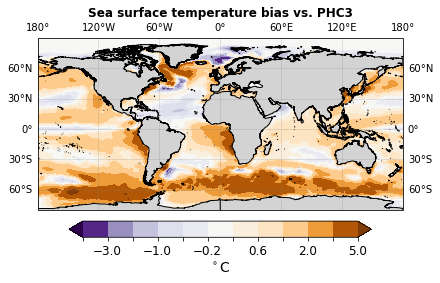

In [44]:
import json
import math as mt
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pkg_resources
import shapely
from cmocean import cm as cmo

import logging
import os
from collections import namedtuple

import joblib
import numpy as np
import scipy.spatial.qhull as qhull
import xarray as xr
from numba import jit
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator
from scipy.spatial import cKDTree

import json
import math as mt
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pkg_resources
import shapely
from cmocean import cm as cmo
try:
    import cartopy.feature as cfeature
except ImportError:
    print("Cartopy is not installed, plotting is not available.")


try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.util import add_cyclic_point
except ImportError:
    print("Cartopy is not installed, plotting is not available.")
    
from matplotlib import cm, ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sfmt = ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((-3, 4))

levels = [-5.0,-3.0,-2.0,-1.0,-.6,-.2,.2,.6,1.0,2.0,3.0,5.0]

figsize=(6, 4.5)
dpi=300

if not identical:
    plot(mesh, 
        plot_data,
        rowscol=rowscol,
        mapproj=mapproj,
        cmap='PuOr_r', 
        levels=levels,
        figsize = figsize, 
        box=bbox, 
        res = res,
        units = units,
        titles = "Sea surface temperature bias vs. PHC3");
    
ofile="sst-phc3"
if ofile is not None:
    plt.savefig(ofile, dpi=dpi, bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')